## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

In [34]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


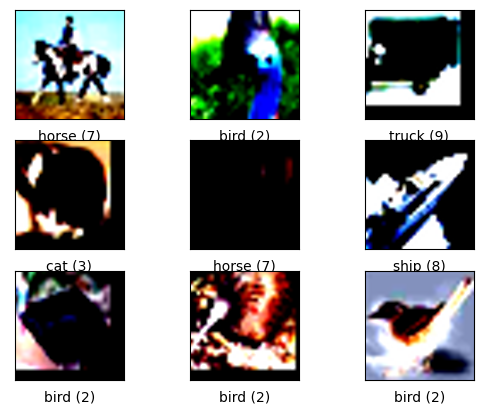

In [36]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])

    train_transform_aug = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    train_transform_normal = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    if augment:
      train_dataset_1 = datasets.CIFAR10(
          root=data_dir, train=True,
          download=True, transform=train_transform_aug,
      )
      train_dataset_2 = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform_normal,
      )
      train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])

    else:
      train_dataset = datasets.CIFAR10(
          root=data_dir, train=True,
          download=True, transform=train_transform_normal,
      )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )
    if augment:
       valid_dataset = torch.utils.data.ConcatDataset([valid_dataset, valid_dataset])


    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader(augment=True)

In [48]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        # Define convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=n_input_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv_5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Assuming input image size is 32x32 after two max pooling layers
        self.fc2 = nn.Linear(128, n_output)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################

        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.pool(x)

        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = self.pool(x)

        x = F.relu(self.conv_5(x))
        x = F.relu(self.conv_6(x))
        x = self.pool(x)

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # First fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        
        # Second fully connected layer
        x = self.fc2(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits,dim=1)

net = ConvNet()


In [51]:
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

optimizer = torch.optim.SGD(net.parameters(), lr=0.003, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5
steps = 0
running_loss = 0
print_every = 200
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        optimizer.zero_grad()
        output = net.predict(images)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, labels)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                preds = net.predict(images).data
                accuracy += (labels == preds.max(1)[1]).type_as(torch.FloatTensor()).mean()
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

Epoch: 1/5.. Loss: 2.1977.. Test accuracy: 0.2627.. 0.0586 s/batch
Epoch: 1/5.. Loss: 2.1891.. Test accuracy: 0.2695.. 0.0537 s/batch
Epoch: 1/5.. Loss: 2.1744.. Test accuracy: 0.2842.. 0.0546 s/batch
Epoch: 1/5.. Loss: 2.1590.. Test accuracy: 0.2949.. 0.0533 s/batch
Epoch: 1/5.. Loss: 2.1543.. Test accuracy: 0.2998.. 0.0572 s/batch
Epoch: 1/5.. Loss: 2.1511.. Test accuracy: 0.3140.. 0.0654 s/batch
Epoch: 1/5.. Loss: 2.1452.. Test accuracy: 0.3188.. 0.0617 s/batch
Epoch: 2/5.. Loss: 2.1411.. Test accuracy: 0.3237.. 0.0209 s/batch


Save best trained model.

In [ ]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
torch.save(net.state_dict(), './CNN_Classifier_6.ckpt')